
# FC-by-timepoints for Multi layer community detection algorithm

This notebook loads rs-fMRI runs, extracts region-wise timeseries using a label atlas, concatenates each subject’s two runs, applies an overlapping sliding window (default: **30 s** window, **1 TR** step), and computes a **Pearson correlation** Functional Connectivity (FC) matrix per window.  
It organizes the outputs as tensors with shape **(subjects × windows × regions × regions)** per group, and prints final tensor sizes for each group.

**defaults params**
- Total scan per subject: 14 minutes (two runs of ~7 minutes each)
- TR = 2 s → ~420 TRs per concatenated run
- TR drop per run: e.g., dropping 5 TRs at the start of each 7-min run → 205 + 205 = 410 TRs.
- Window length = 30 s → 15 TRs
- $N_{win} = T − W + 1$; 
- Step size = 1 TR; number of windows $N_{win} = 410 − 15 + 1 = 396$


## 1. Imports & Configuration

In [1]:
import os, glob, logging
from dataclasses import dataclass
from typing import Dict, List, Tuple
from datetime import datetime
from scipy.io import savemat

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from nilearn import datasets, plotting
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

/Users/ismaila/anaconda3/envs/analysis/lib/python3.11/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
# ---- OOP Environment var ----
@dataclass
class Config:
    data_path: str
    groups: List[str]                 # e.g., ['cFES_Pre','cycling_Pre','cFES_Post','cycling_Post']
    tr: float = 2.0                   # seconds
    window_length_sec: float = 30.0   # seconds
    step_size_tr: int = 1             # in TRs
    fmri_prefix: str = "errts"        # file prefix
    expect_regions: int = 200         # atlas parcels
    runs_per_subject: int = 2
    verbose: bool = True

cfg = Config(
    data_path="/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/fes_data",
    # groups=["cFES_Pre", "cycling_Pre", "cFES_Post", "cycling_Post"],
    groups=["pre_fes", "pre_nfes", "post_fes", "post_nfes"],
    tr=2.0,
    window_length_sec=30.0,
    step_size_tr=1,
    fmri_prefix="errts",
    expect_regions=200,
    runs_per_subject=2,
    verbose=True,
)

print(f"   Data path: {cfg.data_path}")
print(f"   Groups: {cfg.groups}")
print(f"   TR: {cfg.tr}s | Window: {cfg.window_length_sec}s | Step: {cfg.step_size_tr} TR")

   Data path: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/fes_data
   Groups: ['pre_fes', 'pre_nfes', 'post_fes', 'post_nfes']
   TR: 2.0s | Window: 30.0s | Step: 1 TR


## 2. Atlas Fetch & Quick Visual Check

Atlas ROIs are located in nifti image at: /Users/ismaila/nilearn_data/schaefer_2018/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_1mm.nii.gz


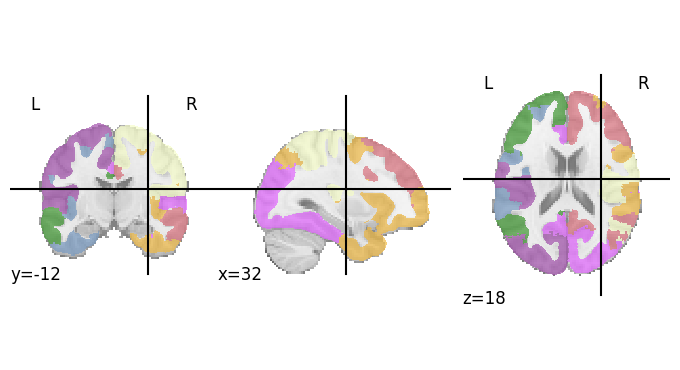

In [3]:
# Atlas Setup & Quick Visualization (Schaefer-2018, 200 parcels, Yeo-7)

start_time = datetime.now()

atlas = datasets.fetch_atlas_schaefer_2018(n_rois=cfg.expect_regions, yeo_networks=7, resolution_mm=1)
atlas_filename = atlas.maps
labels = np.asarray(atlas.labels).astype('U')

# Yeo-7 inspired palette (7 colors)
my_colors = ['#A251AC', '#789AC1', '#409832', '#E165FE', '#F6FDC9', '#EFB944', '#D9717D']
cmap = ListedColormap(my_colors)

# Plot the atlas (display only, do not save)
disp = plotting.plot_roi(atlas_filename, cmap=cmap)
print(f'Atlas ROIs are located in nifti image at: {atlas_filename}')


## 3. Build Masker (Atlas-Based Time Series Extraction)

In [4]:
masker = NiftiLabelsMasker(
    labels_img=atlas_filename,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    memory="nilearn_cache",
    verbose=0,
    t_r=cfg.tr,
)

# connectome = ConnectivityMeasure(kind="correlation")
connectome = ConnectivityMeasure(kind="correlation", standardize="zscore_sample")

print(" Masker & ConnectivityMeasure Done ✅")
print(f"   Masker TR: {cfg.tr}s | Standardize: zscore_sample")
print(f"   FC kind: Pearson correlation")


 Masker & ConnectivityMeasure Done ✅
   Masker TR: 2.0s | Standardize: zscore_sample
   FC kind: Pearson correlation


## 4. Utils: Raw NIfTI Files (Per Group) & Verify Pairing

In [5]:
def list_group_niis(group_dir: str, prefix: str) -> List[str]:
    patt1 = os.path.join(group_dir, f"{prefix}*.nii")
    patt2 = os.path.join(group_dir, f"{prefix}*.nii.gz")
    files = sorted(glob.glob(patt1) + glob.glob(patt2))
    return files

def pair_runs_consecutively(run_paths: List[str], runs_per_subject: int = 2) -> List[Tuple[str, ...]]:
    if len(run_paths) % runs_per_subject != 0:
        raise ValueError(
            f"Found {len(run_paths)} runs, not divisible by runs_per_subject={runs_per_subject}."
        )
    pairs = []
    for i in range(0, len(run_paths), runs_per_subject):
        pairs.append(tuple(run_paths[i : i + runs_per_subject]))
    return pairs

group_runs: Dict[str, List[str]] = {}
group_pairs: Dict[str, List[Tuple[str, ...]]] = {}

print("Scanning groups for raw NIfTI runs...")
for grp in cfg.groups:
    grp_dir = os.path.join(cfg.data_path, grp)
    if not os.path.isdir(grp_dir):
        raise FileNotFoundError(f"Group directory not found: {grp_dir}")

    runs = list_group_niis(grp_dir, cfg.fmri_prefix)
    group_runs[grp] = runs
    pairs = pair_runs_consecutively(runs, cfg.runs_per_subject)
    group_pairs[grp] = pairs

    # Summary
    print(f"   [{grp}] runs: {len(runs)} | subjects (by pairing): {len(pairs)}")
    if len(runs) > 0:
        print(f"     first 4 runs: {runs[:4]}")
    if len(pairs) > 0:
        print(f"     first pairing: {pairs[0]}")


Scanning groups for raw NIfTI runs...
   [pre_fes] runs: 14 | subjects (by pairing): 7
     first 4 runs: ['/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/fes_data/pre_fes/errts.scifes03a.r01.fanaticor+tlrc.nii.gz', '/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/fes_data/pre_fes/errts.scifes03a.r02.fanaticor+tlrc.nii.gz', '/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/fes_data/pre_fes/errts.scifes07a.r01.fanaticor+tlrc.nii.gz', '/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/fes_data/pre_fes/errts.scifes07a.r02.fanaticor+tlrc.nii.gz']
     first pairing: ('/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/fes_data/pre_fes/errts.scifes03a.r01.fanaticor+tlrc.nii.gz', '/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/fes_data/pre_fes/errts.scifes03a.r02.fanaticor+tlrc.nii.gz')
   [pre_nfes] runs: 10 | subjects (by pairing): 5
     first 4 runs: ['/Users/ismaila/Documents/C-Codes/SCI_FES_Grap

## 5. Helpers: Extract TS, Concatenate, Windowing, FC

In [6]:
def extract_run_timeseries(nii_path: str) -> np.ndarray:
    ts = masker.fit_transform(nii_path)  # (T, R)
    if ts.ndim != 2:
        raise ValueError(f"Timeseries not 2D for {nii_path}: {ts.shape}")
    if ts.shape[1] != cfg.expect_regions:
        raise ValueError(f"Expected {cfg.expect_regions} regions, got {ts.shape[1]} in {nii_path}")
    return ts

def concat_subject_runs(run_ts_list: List[np.ndarray]) -> np.ndarray:
    region_counts = {ts.shape[1] for ts in run_ts_list}
    if len(region_counts) != 1:
        raise ValueError(f"Region mismatch across runs: {region_counts}")
    return np.concatenate(run_ts_list, axis=0)

def sliding_window_indices(n_timepoints: int, window_trs: int, step_trs: int) -> List[Tuple[int, int]]:
    idx = []
    s = 0
    while s + window_trs <= n_timepoints:
        idx.append((s, s + window_trs))
        s += step_trs
    return idx

def timeseries_to_window_list(ts: np.ndarray, window_trs: int, step_trs: int) -> List[np.ndarray]:
    idx = sliding_window_indices(ts.shape[0], window_trs, step_trs)
    return [ts[s:e, :] for (s, e) in idx]

def compute_fc_per_window(windows: List[np.ndarray]) -> np.ndarray:
    if len(windows) == 0:
        return np.zeros((0, 0, 0), dtype=np.float32)
    fc_list = connectome.fit_transform(windows)  # (n_windows, R, R)
    return np.asarray(fc_list, dtype=np.float32)



## 6. Parameter Translation & Sanity Check

In [7]:
# Parameter Translation & Sanity check

window_trs = int(round(cfg.window_length_sec / cfg.tr))
step_trs = int(cfg.step_size_tr)

if window_trs < 2:
    raise ValueError("window_trs must be >= 2.")
if step_trs < 1:
    raise ValueError("step_trs must be >= 1.")

expected_trs_per_run = int(round(7 * 60 / cfg.tr))  # ~7 minutes per run
print(f"   window_trs: {window_trs} (from {cfg.window_length_sec}s @ TR={cfg.tr}s)")
print(f"   step_trs:   {step_trs}")
print(f"   expected TRs per run (≈7min): {expected_trs_per_run}")


   window_trs: 15 (from 30.0s @ TR=2.0s)
   step_trs:   1
   expected TRs per run (≈7min): 210


## 7. Run on One Subject (Group1 or cFES_Pre)

In [8]:
# One Subject Test (First Group)

test_grp = cfg.groups[0]
if len(group_pairs[test_grp]) == 0:
    raise RuntimeError(f"No subject pairings in group: {test_grp}")

test_pair = group_pairs[test_grp][0]
run_ts_list = []

print(f"run on group '{test_grp}', subject pair:")
for rp in test_pair:
    print(f"   - Extracting TS: {os.path.basename(rp)}")
    ts = extract_run_timeseries(rp)
    run_ts_list.append(ts)
    # Warn if TR count deviates notably from ~210 for 7min@2s
    if abs(ts.shape[0] - expected_trs_per_run) > 10:
        print(f"     [warn] timepoints={ts.shape[0]} (expected ~{expected_trs_per_run})")
    print(f"     TS shape: {ts.shape}")

ts_concat = concat_subject_runs(run_ts_list)
print(f"   Concatenated TS shape: {ts_concat.shape} (expect ~420 x {cfg.expect_regions})")

windows = timeseries_to_window_list(ts_concat, window_trs, step_trs)
print(f"   Windows created: {len(windows)} (expect ~{ts_concat.shape[0] - window_trs + 1} for step=1)")

fc_w = compute_fc_per_window(windows)
print(f"   FC per-window shape: {fc_w.shape}  (windows x {cfg.expect_regions} x {cfg.expect_regions})")

assert fc_w.ndim == 3 and fc_w.shape[1] == cfg.expect_regions and fc_w.shape[2] == cfg.expect_regions
print("Test done ✅")


run on group 'pre_fes', subject pair:
   - Extracting TS: errts.scifes03a.r01.fanaticor+tlrc.nii.gz
     TS shape: (205, 200)
   - Extracting TS: errts.scifes03a.r02.fanaticor+tlrc.nii.gz
     TS shape: (205, 200)
   Concatenated TS shape: (410, 200) (expect ~420 x 200)
   Windows created: 396 (expect ~396 for step=1)
   FC per-window shape: (396, 200, 200)  (windows x 200 x 200)
Test done ✅


## 8. Pipeline: All Groups-to-FC Tensors

In [9]:
# Full Processing: All Groups → FC Tensors (with Checks)

group_fc_results: Dict[str, np.ndarray] = {}
print("Processing all groups...")

for grp in cfg.groups:
    pairs = group_pairs[grp]
    if len(pairs) == 0:
        print(f"   [{grp}] No subjects found; skipping.")
        continue

    subj_fc_list = []
    n_windows_ref = None

    print(f"   [{grp}] subjects={len(pairs)}")
    for si, pair in enumerate(pairs, start=1):
        run_ts_list = []
        for rp in pair:
            ts = extract_run_timeseries(rp)
            # Quick TR sanity check
            if abs(ts.shape[0] - expected_trs_per_run) > 10 and cfg.verbose:
                print(f"     [warn] {os.path.basename(rp)}: timepoints={ts.shape[0]} (expected ~{expected_trs_per_run})")
            run_ts_list.append(ts)

        ts_concat = concat_subject_runs(run_ts_list)
        windows = timeseries_to_window_list(ts_concat, window_trs, step_trs)
        if len(windows) == 0:
            raise ValueError(f"No windows for subject {si} in group {grp} (T={ts_concat.shape[0]}, window_trs={window_trs}).")

        fc_w = compute_fc_per_window(windows)

        if n_windows_ref is None:
            n_windows_ref = fc_w.shape[0]
        elif fc_w.shape[0] != n_windows_ref:
            raise ValueError(f"[{grp}] Inconsistent window counts across subjects: first had {n_windows_ref}, now {fc_w.shape[0]}")

        subj_fc_list.append(fc_w)
        if cfg.verbose:
            print(f"     Subject {si}: TS {ts_concat.shape} | windows={fc_w.shape[0]} | FC shape={fc_w.shape}")

    grp_tensor = np.stack(subj_fc_list, axis=0).astype(np.float32)  # (subjects, windows, R, R)
    group_fc_results[grp] = grp_tensor
    print(f"   [{grp}] FC tensor: {grp_tensor.shape} (subjects x windows x {cfg.expect_regions} x {cfg.expect_regions})")

print("All groups processed Done✅")


Processing all groups...
   [pre_fes] subjects=7
     Subject 1: TS (410, 200) | windows=396 | FC shape=(396, 200, 200)


/Users/ismaila/anaconda3/envs/analysis/lib/python3.11/site-packages/nilearn/connectome/connectivity_matrices.py:346: RuntimeWarning: divide by zero encountered in divide
  diagonal = np.atleast_2d(1.0 / np.sqrt(np.diag(covariance)))
/Users/ismaila/anaconda3/envs/analysis/lib/python3.11/site-packages/nilearn/connectome/connectivity_matrices.py:347: RuntimeWarning: invalid value encountered in multiply
  correlation = covariance * diagonal * diagonal.T


     Subject 2: TS (410, 200) | windows=396 | FC shape=(396, 200, 200)
     Subject 3: TS (410, 200) | windows=396 | FC shape=(396, 200, 200)
     Subject 4: TS (410, 200) | windows=396 | FC shape=(396, 200, 200)
     Subject 5: TS (410, 200) | windows=396 | FC shape=(396, 200, 200)
     Subject 6: TS (410, 200) | windows=396 | FC shape=(396, 200, 200)
     Subject 7: TS (410, 200) | windows=396 | FC shape=(396, 200, 200)
   [pre_fes] FC tensor: (7, 396, 200, 200) (subjects x windows x 200 x 200)
   [pre_nfes] subjects=5
     Subject 1: TS (410, 200) | windows=396 | FC shape=(396, 200, 200)
     Subject 2: TS (410, 200) | windows=396 | FC shape=(396, 200, 200)
     Subject 3: TS (410, 200) | windows=396 | FC shape=(396, 200, 200)
     Subject 4: TS (410, 200) | windows=396 | FC shape=(396, 200, 200)
     Subject 5: TS (410, 200) | windows=396 | FC shape=(396, 200, 200)
   [pre_nfes] FC tensor: (5, 396, 200, 200) (subjects x windows x 200 x 200)
   [post_fes] subjects=7
     Subject 1: 

## 9. Inspect Results (Shapes, Counts, Example Subject/Window)

In [11]:
def describe_group(group_key: str, result_map: Dict[str, np.ndarray]):
    arr = result_map[group_key]
    n_subj, n_win, r1, r2 = arr.shape
    print(f"Group={group_key}: subjects={n_subj}, windows={n_win}, regions={r1}x{r2}")
    return n_subj, n_win, r1, r2

# Example:
if 'group_fc_results' in globals():
    for g in cfg.groups:
        describe_group(g, group_fc_results)
    # Peek at one subject/window
    g0 = cfg.groups[0]
    FC_example = group_fc_results[g0][0, 0]  # subject 0, window 0 -> (200, 200)
    print("Example FC matrix stats:", np.min(FC_example), np.max(FC_example), np.mean(FC_example))


Group=pre_fes: subjects=7, windows=396, regions=200x200
Group=pre_nfes: subjects=5, windows=396, regions=200x200
Group=post_fes: subjects=7, windows=396, regions=200x200
Group=post_nfes: subjects=5, windows=396, regions=200x200
Example FC matrix stats: -0.81820315 1.0 0.6151183


## 10. Visualization of One FC Matrix

        pre_fes: (7, 396, 200, 200)
       pre_nfes: (5, 396, 200, 200)
       post_fes: (7, 396, 200, 200)
      post_nfes: (5, 396, 200, 200)

   Example from [pre_fes] subj 2, win 1 -> FC stats: min=-0.6124, max=1.0000, mean=0.4252


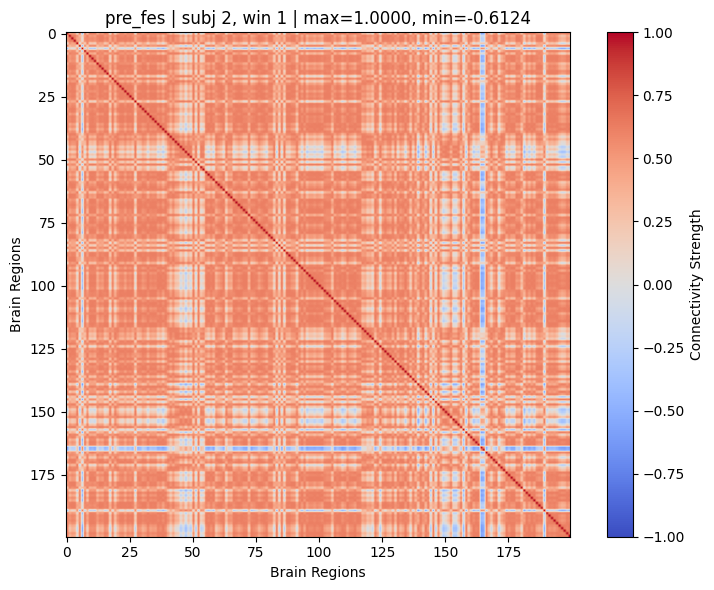

In [12]:
# Summary of FC tensors (subjects x windows x regions x regions)
for g, arr in group_fc_results.items():
    print(f"   {g:>12}: {arr.shape}")

# ----- Choose which group / subject / window to visualize -----
g_idx = 0   # index into cfg.groups (0-based). Change this to pick a different group.
subj  = 2   # subject number (min is 1). Change this to pick a different subject.
win   = 1   # window number  (min is 1). Change this to pick a different window.
# --------------------------------------------------------------

if len(group_fc_results) > 0:
    # Validate group index
    if not (0 <= g_idx < len(cfg.groups)):
        print(f"   Invalid g_idx={g_idx}. Valid range is 0..{len(cfg.groups)-1}.")
    else:
        g0 = cfg.groups[g_idx]
        if g0 in group_fc_results and group_fc_results[g0].size > 0:
            arr = group_fc_results[g0]
            n_subj, n_win, r1, r2 = arr.shape

            # Validate subj/win (1-based)
            if not (1 <= subj <= n_subj):
                print(f"   Invalid subj={subj}. Valid range for [{g0}] is 1..{n_subj}.")
            elif not (1 <= win <= n_win):
                print(f"   Invalid win={win}. Valid range for [{g0}] is 1..{n_win}.")
            else:
                subj_idx = subj - 1
                win_idx  = win  - 1

                FC_example = arr[subj_idx, win_idx]  # (R, R)
                print(f"\n   Example from [{g0}] subj {subj}, win {win} -> FC stats: "
                      f"min={np.min(FC_example):.4f}, max={np.max(FC_example):.4f}, mean={np.mean(FC_example):.4f}")

                fig, ax = plt.subplots(figsize=(8, 6))
                im = ax.imshow(FC_example, cmap='coolwarm', vmin=-1, vmax=1)
                ax.set_title(f'{g0} | subj {subj}, win {win} | max={np.max(FC_example):.4f}, min={np.min(FC_example):.4f}')
                ax.set_xlabel('Brain Regions')
                ax.set_ylabel('Brain Regions')
                fig.colorbar(im, ax=ax, label='Connectivity Strength')
                plt.tight_layout()
                plt.show()
        else:
            print("   No FC results available to visualize for the selected group.")
else:
    print("   group_fc_results is empty.")


        pre_fes: (7, 396, 200, 200)
       pre_nfes: (5, 396, 200, 200)
       post_fes: (7, 396, 200, 200)
      post_nfes: (5, 396, 200, 200)


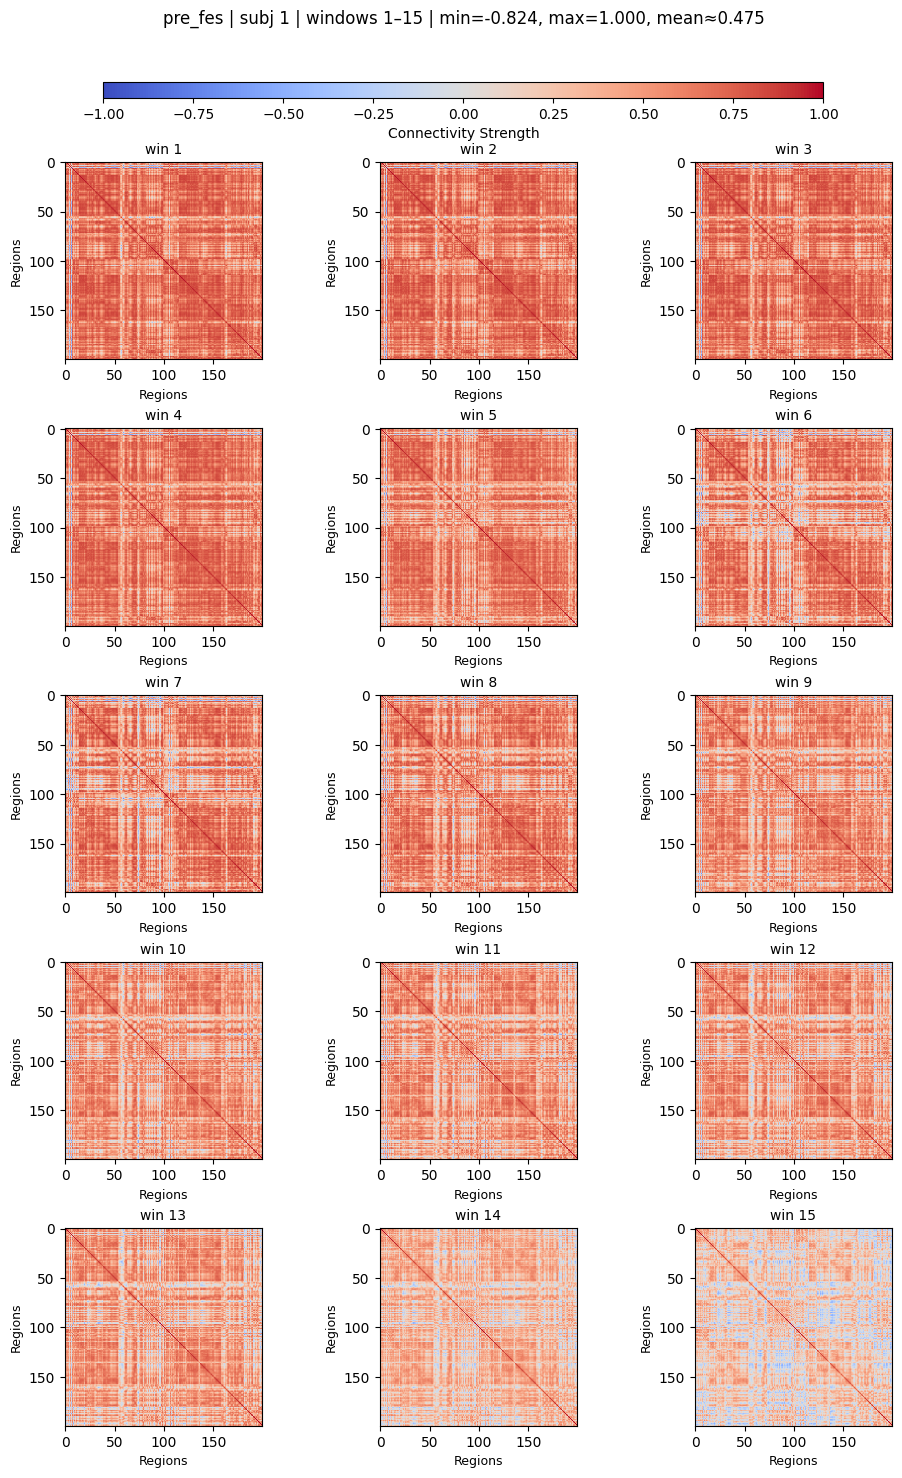

In [56]:
for g, arr in group_fc_results.items():
    print(f"   {g:>12}: {arr.shape}")

g_idx = 0   
subj  = 1   
win   = 1   
# Grid layout
n_cols = 3  
n_rows = 5 # window-based FCs
# --------------------------------------------------------------

if len(group_fc_results) > 0:
    # Validate group index
    if not (0 <= g_idx < len(cfg.groups)):
        print(f"   Invalid g_idx={g_idx}. Valid range is 0..{len(cfg.groups)-1}.")
    else:
        g0 = cfg.groups[g_idx]
        if g0 in group_fc_results and group_fc_results[g0].size > 0:
            arr = group_fc_results[g0]
            n_subj, n_win, r1, r2 = arr.shape

            # Validate subj/win (1-based)
            if not (1 <= subj <= n_subj):
                print(f"   Invalid subj={subj}. Valid range for [{g0}] is 1..{n_subj}.")
            elif not (1 <= win <= n_win):
                print(f"   Invalid win={win}. Valid range for [{g0}] is 1..{n_win}.")
            else:
                subj_idx = subj - 1
                start_w  = win - 1
                max_panels = n_cols * n_rows
                end_w   = min(start_w + max_panels, n_win)  # exclusive
                k = end_w - start_w
                if k <= 0:
                    print(f"   No windows available from win={win} in [{g0}].")
                else:
                    # Prepare figure grid
                    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4.0, n_rows*3.2))
                    axes = axes.ravel()

                    # Track global stats over displayed windows
                    mins, maxs, means = [], [], []

                    im = None
                    for i in range(n_cols * n_rows):
                        ax = axes[i]
                        if i < k:
                            w_idx = start_w + i
                            FC_example = arr[subj_idx, w_idx]  # (R, R)
                            mins.append(np.min(FC_example))
                            maxs.append(np.max(FC_example))
                            means.append(np.mean(FC_example))

                            im = ax.imshow(FC_example, cmap='coolwarm', vmin=-1, vmax=1)
                            ax.set_title(f'win {w_idx+1}', fontsize=10)
                            ax.set_xlabel('Regions', fontsize=9)
                            ax.set_ylabel('Regions', fontsize=9)
                        else:
                            ax.axis('off')

                    # One shared colorbar for all subplots
                    if im is not None:
                        #cbar = fig.colorbar(im, ax=axes.tolist(), location='top', orientation='horizontal', fraction=0.02, pad=0.01, label='Connectivity Strength')
                        
                        cax = fig.add_axes([0.2, 0.94, 0.6, 0.01])  # [left, bottom, width, height] in figure coords
                        cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
                        cbar.set_label('Connectivity Strength')

                        # leave space for the top bar and tighten subplot spacing if needed
                        fig.subplots_adjust(top=0.90, wspace=0.05, hspace=0.35)

                        
                    # Suptitle with context and summary stats
                    if k > 0:
                        fig.suptitle(
                            f'{g0} | subj {subj} | windows {start_w+1}–{start_w+k} '
                            f'| min={np.min(mins):.3f}, max={np.max(maxs):.3f}, mean≈{np.mean(means):.3f}',
                            fontsize=12, y=0.995
                        )
                    #plt.tight_layout(rect=[0, 0, 1, 0.98])
                    plt.show()
        else:
            print("   No FC results available to visualize for the selected group.")
else:
    print("   group_fc_results is empty.")


## Save outputs for Multi-layer community detection algorithm

In [13]:
# Save correlations to .mat (one file; variables named corr_<group>)

corr_path = '/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/fc/'

if 'group_fc_results' not in globals() or len(group_fc_results) == 0:
    print("No FC results available to save")
else:
    if corr_path:
        os.makedirs(corr_path, exist_ok=True)

        # Build the dict with MATLAB-safe variable names: corr_<group>
        corr_data = {}
        for g, arr in group_fc_results.items():
            # Sanitize group name for MATLAB variable rules
            safe_g = ''.join(ch if (ch.isalnum() or ch == '_') else '_' for ch in g)
            if not safe_g or not safe_g[0].isalpha():
                safe_g = f"grp_{safe_g}"
            var_name = f"corr_{safe_g}"
            corr_data[var_name] = arr  # shape: (subjects, windows, regions, regions)

        out_file = os.path.join(corr_path, "corr_all_groups.mat")
        savemat(out_file, corr_data)

        print(f"Saved MATLAB file with {len(corr_data)} variables:")
        for k, v in corr_data.items():
            print(f"    {k}: {v.shape}")
        print(f"    -> {out_file}")
    else:
        print("Skipped saving (.mat). Set 'corr_path' to a valid directory to enable.")


Saved MATLAB file with 4 variables:
    corr_pre_fes: (7, 396, 200, 200)
    corr_pre_nfes: (5, 396, 200, 200)
    corr_post_fes: (7, 396, 200, 200)
    corr_post_nfes: (5, 396, 200, 200)
    -> /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/fc/corr_all_groups.mat


In [14]:
# Save correlations as separate variables with clear names
#    - One .mat per group
#    - Inside each file, one variable per subject:
#         corr_<group>_subjXX  -> array shape: (windows, regions, regions)

corr_path = '/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/fc/'

if 'group_fc_results' not in globals() or len(group_fc_results) == 0:
    print("No FC results available to save.")
else:
    os.makedirs(corr_path, exist_ok=True)

    def _safe_var_name(name: str) -> str:
        # MATLAB variable rules: start with letter, then [A-Za-z0-9_]
        s = ''.join(ch if (ch.isalnum() or ch == '_') else '_' for ch in name)
        if not s or not s[0].isalpha():
            s = f"grp_{s}"
        return s

    for g, arr in group_fc_results.items():
        # arr shape: (subjects, windows, regions, regions)
        n_subj, n_win, r1, r2 = arr.shape
        safe_g = _safe_var_name(g)

        # Build per-subject variables for this group
        mat_data = {}
        for si in range(n_subj):
            var_name = f"corr_{safe_g}_subj{si+1:02d}"
            # (windows, regions, regions)
            mat_data[var_name] = arr[si]  # arr[si] -> (n_win, r1, r2)

        out_file = os.path.join(corr_path, f"corr_{safe_g}_by_subject.mat")
        savemat(out_file, mat_data)

        print(f"Saved {out_file} with {len(mat_data)} variables:")
        # Print a short preview
        preview = list(mat_data.items())[:8]
        for k, v in preview:
            print(f"    {k}: {v.shape}")
        if len(mat_data) > 8:
            print(f"    ... ({len(mat_data)-8} more subjects)")


Saved /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/fc/corr_pre_fes_by_subject.mat with 7 variables:
    corr_pre_fes_subj01: (396, 200, 200)
    corr_pre_fes_subj02: (396, 200, 200)
    corr_pre_fes_subj03: (396, 200, 200)
    corr_pre_fes_subj04: (396, 200, 200)
    corr_pre_fes_subj05: (396, 200, 200)
    corr_pre_fes_subj06: (396, 200, 200)
    corr_pre_fes_subj07: (396, 200, 200)
Saved /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/fc/corr_pre_nfes_by_subject.mat with 5 variables:
    corr_pre_nfes_subj01: (396, 200, 200)
    corr_pre_nfes_subj02: (396, 200, 200)
    corr_pre_nfes_subj03: (396, 200, 200)
    corr_pre_nfes_subj04: (396, 200, 200)
    corr_pre_nfes_subj05: (396, 200, 200)
Saved /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/fc/corr_post_fes_by_subject.mat with 7 variables:
    corr_post_fes_subj01: (396, 200, 200)
    corr_post_fes_subj02: (396, 200, 200)
    corr_post_fes_subj03: (396, 200, 200)
    co

In [48]:
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 4:19:53.206852
